In [13]:
"""
    author: Suhas Vittal
    date:   7 March 2024
"""

surface_codes = [
    'hysc/3_8/48_6_6_3',
    'hysc/3_8/96_10_10_4',
    'hysc/3_8/504_44_14_6',
    'hysc/4_6/36_8_4_4',
    'hysc/4_6/336_58_8_6',
    'hysc/4_6/864_146_10_8',
#    'hysc/5_5/30_8_3_3',
#    'hysc/5_5/80_18_5_5',
#    'hysc/5_5/150_32_6_6',
#    'hysc/5_5/900_182_8_8'
]

color_codes = [
#    'hycc/3_8/48_8_4_4',
    'hycc/4_6/24_8_4_4',
    'hycc/4_6/96_20_6_6',
    'hycc/4_6/192_36_8_8',
#    'hycc/4_6/1536_260_12_12',
    'hycc/4_10/40_16_4_4',
#    'hycc/4_10/480_148_6_6',
#    'hycc/4_10/640_196_8_8'
]

all_codes = [*surface_codes, *color_codes]

# Color palette:
c1 = '#7D0A0A'
c2 = '#BF3131'
c3 = '#EAD196'
c4 = '#F3EDC8'
c5 = '#004225'
c6 = '#F5F5DC'
c7 = '#FFB000'
c8 = '#FFCF9D'

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from collections import defaultdict

import os

plt.rcParams['pdf.fonttype'] = 42

In [57]:
def split_csv_line(line: str, delim=',') -> list[str]:
    dat = []
    in_quote = False
    curr = []
    for c in line:
        if c == '\"':
            in_quote = not in_quote
        elif c == ',':
            if in_quote:
                curr.append(c)
            else:
                dat.append(''.join(curr))
                curr = []
        else:
            curr.append(c)
    dat.append(''.join(curr))
    return dat

def get_arch_stats(benchmark, version):
    fname = f'../../data/protean/{benchmark}/v{version}/stats.txt'
    with open(fname, 'r') as reader:
        lines = reader.readlines()[1:] # Ignore the first line -- just a header.
    stats = {}
    for line in lines:
        d = line.split(',')
        stats[d[0]] = float(d[1])
    return stats

def code_name(benchmark):
    return benchmark.split('/')[2]

def get_stats_from_code_name(name):
    # Format is n_k_dz_dx
    d = name.split('_')
    return { 'n': int(d[0]), 'k': int(d[1]), 'dz': int(d[2]), 'dx': int(d[3]) }

def format_code_name(name):
    stats = get_stats_from_code_name(name)
    n, k, dz, dx = stats['n'], stats['k'], stats['dz'], stats['dx']
    return '[[%d, %d, %d, %d]]' % (n, k, dz, dx) 

def get_error_rates_from_file(f, ler_key=-1):
    with open(f, 'r') as reader:
        lines = reader.readlines()[1:]
    X, Y = [], []
    for line in lines:
        d = line.split(',')
        if float(d[-1]) > 0:
            X.append(float(d[0]))
            Y.append(float(d[ler_key]))
    X, Y = zip(*sorted(zip(X, Y)))
    return X, Y

def get_rsc_error_rates(d, mem):
    f = f'../../data/protean/rsc/output/{mem}_d{d}.csv'
    return get_error_rates_from_file(f)

def get_hexcc_error_rates(d, mem):
    f = f'../../data/protean/hexcc/output/{mem}_d{d}.csv'
    return get_error_rates_from_file(f)

def get_code_error_rates(code, version, ler_key=-1):
    f = f'../../data/protean/{code}/v{version}/output/basic_memory_z.csv'
    return get_error_rates_from_file(f, ler_key=ler_key)


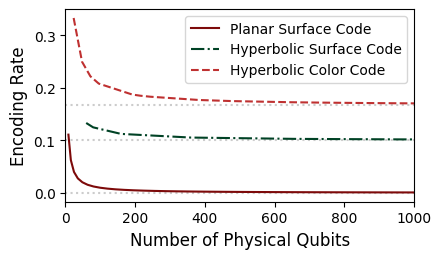

In [16]:
### Introduction Rate Plot:
fig, ax = plt.subplots()
fig.set_size_inches(4.5, 2.5)

sc_d = np.arange(3, 33)
sc_n = [d**2 for d in sc_d]
sc_r = [1.0/(d**2) for d in sc_d]

# 5_5 family
#hysc_n = [30, 40, 80, 150, 330, 480, 900, 1280]
#hysc_r = [8/30, 10/40, 18/80, 32/150, 68/330, 98/480, 182/900, 258/1280]
# 4_5 family
hysc_n = [60, 80, 160, 360, 660, 960, 1280]
hysc_r = [8/60, 10/80, 18/160, 38/360, 68/660, 98/960, 130/1280] 

# 4_8 family
hycc_n = [24, 48, 72, 96, 192, 216, 244, 384, 480, 648, 720, 768, 865, 960, 1152]
hycc_r = [8/24, 12/48, 16/72, 20/96, 36/192, 40/216, 44/240, 68/384, 84/480, 112/648, 124/720, 132/768, 148/864, 164/960, 196/1152]

ax.axhline(y=0.0, linestyle=':', color='#cccccc')
ax.axhline(y=1/10, linestyle=':', color='#cccccc')
ax.axhline(y=1/6, linestyle=':', color='#cccccc')
ax.plot(sc_n, sc_r, '-', color=c1, label='Planar Surface Code')
ax.plot(hysc_n, hysc_r, '-.', color=c5, label='Hyperbolic Surface Code')
ax.plot(hycc_n, hycc_r, '--', color=c2, label='Hyperbolic Color Code')

ax.set_xlabel('Number of Physical Qubits', fontsize=12)
ax.set_ylabel('Encoding Rate', fontsize=12)
ax.set_xlim([0, 1000])
ax.legend(fontsize=10)

plt.savefig('plots/intro_rate_cmp.pdf', bbox_inches='tight')

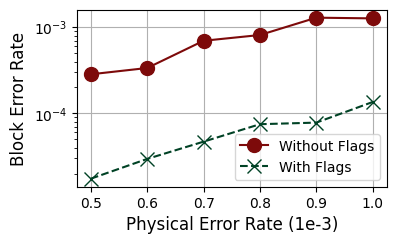

In [56]:
## Background plot
fig, ax = plt.subplots()
fig.set_size_inches(4, 2.3)

code = 'hysc/4_5/60_8_6_4'
x1, y1 = get_code_error_rates(code, '1', -2)
x2, y2 = get_code_error_rates(code, '2', -2)

x1 = [_x*1000 for _x in x1]
x2 = [_x*1000 for _x in x2]

ax.plot(x1, y1, '-o', color=c1, ms=10, label='Without Flags')
ax.plot(x2, y2, '--x', color=c5, ms=10, label='With Flags')

ax.set_xlabel('Physical Error Rate (1e-3)', fontsize=12)
ax.set_ylabel('Block Error Rate', fontsize=12)
ax.set_yscale('log')
ax.grid()
ax.legend(fontsize=10)

plt.savefig('plots/background_ler_flag_cmp.pdf', bbox_inches='tight')

Mean flag overheads for v=3.4: 0.4939694859493792
Mean flag overheads for v=3.4: 0.49078459119002366


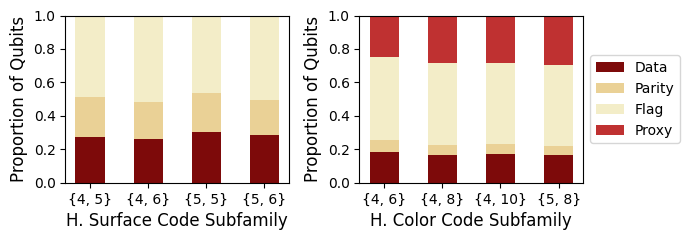

In [49]:
def get_overheads_by_qubit(code, version):
    f = f'../../data/protean/{code}/v{version}/roles.txt'
    with open(f, 'r') as reader:
        lines = reader.readlines()[1:] # First line is header.
    n_data, n_parity, n_flag, n_proxy = 0, 0, 0, 0
    for line in lines:
        dat = split_csv_line(line)
        q, roles = int(dat[0]), dat[2]
        if 'd' in roles:
            n_data += 1
        elif 'x' in roles or 'z' in roles:
            n_parity += 1
        elif 'f' in roles:
            n_flag += 1
        else:
            n_proxy += 1
    tot = n_data + n_parity + n_flag + n_proxy
    n_data /= tot
    n_parity /= tot
    n_flag /= tot
    n_proxy /= tot
    return n_data, n_parity, n_flag, n_proxy

def get_mean_overheads_for_subfamily(family, subfamily, version):
    base_folder = f'../../data/protean/{family}/{subfamily}'
    codes = [f for f in os.listdir(base_folder) if os.path.exists(f'{base_folder}/{f}/v{version}/roles.txt')]
    if len(codes) == 0:
        print(f'No codes for {family}/{subfamily}')
        return 0, 0, 0, 0
    md, mp, mf, mr = 0, 0, 0, 0
    for f in codes:
        nd, np, nf, nr = get_overheads_by_qubit(f'{family}/{subfamily}/{f}', version)
        md += nd
        mp += np
        mf += nf
        mr += nr
    md /= len(codes)
    mp /= len(codes)
    mf /= len(codes)
    mr /= len(codes)
    return md, mp, mf, mr

## Flag Overhead Plot -- no sharing
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(7, 2.5)

subf = {'hysc': ['4_5', '4_6', '5_5', '5_6'], 'hycc': ['4_6', '4_8', '4_10', '5_8']}

version = '3.4'
def add_data_to_ax(ax, family, xlabel):
    data = {'Data': [], 'Parity': [], 'Flag': [], 'Proxy': []}
    for sf in subf[family]:
        md, mp, mf, mr = get_mean_overheads_for_subfamily(family, sf, version)
        data['Data'].append(md)
        data['Parity'].append(mp)
        data['Flag'].append(mf)
        data['Proxy'].append(mr)
    base = np.zeros(len(subf[family]))
    for k in data:
        data[k] = np.array(data[k])
    color_dict = {'Data': c1, 'Parity': c3, 'Flag': c4, 'Proxy': c2}
    code_names = []
    for sf in subf[family]:
        r, s = [int(x) for x in sf.split('_')]
        code_names.append('{%d, %d}' % (r, s))
    for (k, v) in data.items():
        ax.bar(code_names, v, 0.5, label=k, bottom=base, color=color_dict[k])
        base += v
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel('Proportion of Qubits', fontsize=12)
    ax.set_ylim([0.0, 1.0])
    
    print(f'Mean flag overheads for v={version}:', data['Flag'].mean())
add_data_to_ax(ax1, 'hysc', 'H. Surface Code Subfamily')
add_data_to_ax(ax2, 'hycc', 'H. Color Code Subfamily')

#ax1.legend(fontsize=10, bbox_to_anchor=(1.0, 0.5), loc='center left')
ax2.legend(fontsize=10, bbox_to_anchor=(1.0, 0.5), loc='center left')

plt.tight_layout()
plt.savefig('plots/overheads_wo_flag_sharing.pdf')

[1.59523199 2.62230945 3.61783816 4.55766209 2.8818725 ]
2.881872497035174 4.557662092804023
[4.26086957 5.15448944 6.14848379 6.73841555 5.49227695]
5.492276954717547 6.738415545590433


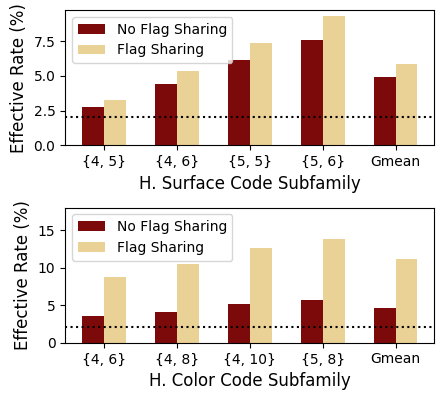

In [133]:
## Effective Rate (FPNs w and w/o flag sharing)
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(4.5, 4.1)

def get_effective_rate(family, subfamily, v):
    base_folder = f'../../data/protean/{family}/{subfamily}'
    codes = [f for f in os.listdir(base_folder) if os.path.exists(f'{base_folder}/{f}/v4.4/roles.txt')]
    tot_k, tot_N = 0, 0
    for f in codes:
        stats = get_arch_stats(f'{family}/{subfamily}/{f}', v)
        tot_k += get_stats_from_code_name(f)['k']
        tot_N += stats['Qubits']
    return tot_k / tot_N

scr = 1/49 * 100

def add_data_to_ax(ax, family, xlabel):
    ax.axhline(y=scr, linestyle=':', color='k')
    
    code_names = []
    y1, y2 = [], []
    for sf in subf[family]:
        r, s = [int(x) for x in sf.split('_')]
        code_names.append('{%d, %d}' % (r, s))
        y1.append(get_effective_rate(family, sf, '3.4')*100)
        y2.append(get_effective_rate(family, sf, '4.4')*100)
    code_names.append('Gmean')
    y1.append(sp.stats.gmean(y1))
    y2.append(sp.stats.gmean(y2))
    x = np.arange(0, len(code_names))
    ax.bar(x, y1, width=0.3, label='No Flag Sharing', color=c1)
    ax.bar(x+0.3, y2, width=0.3, label='Flag Sharing', color=c3)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel('Effective Rate (%)', fontsize=12)
    ax.set_xticks(x+0.15, code_names)
#    ax.grid(visible=True, axis='y')
    ax.legend(fontsize=10)

    y2 = np.array(y2)
    print(y2/scr)
    print(sp.stats.gmean(y2/scr), y2.max()/scr)
ax2.set_ylim([0, 18])
add_data_to_ax(ax1, 'hysc', 'H. Surface Code Subfamily')
add_data_to_ax(ax2, 'hycc', 'H. Color Code Subfamily')
plt.tight_layout()
plt.savefig('plots/eff_rate.pdf', bbox_inches='tight')

160_18_8_6 (4.91287e-07, 7.06425e-07, 1.32455e-06, 1.80138e-06, 2.16166e-06, 2.96699e-06)
160_18_8_6 (2.75506e-06, 5.08626e-06, 1.13381e-05, 1.41992e-05, 2.0557e-05, 3.43323e-05)
150_32_6_6 (3.75509e-06, 5.78165e-06, 8.46386e-06, 1.45435e-05, 2.01464e-05, 3.09944e-05)
150_32_6_6 (4.41074e-06, 6.91414e-06, 1.09673e-05, 1.70469e-05, 2.72989e-05, 3.75509e-05)


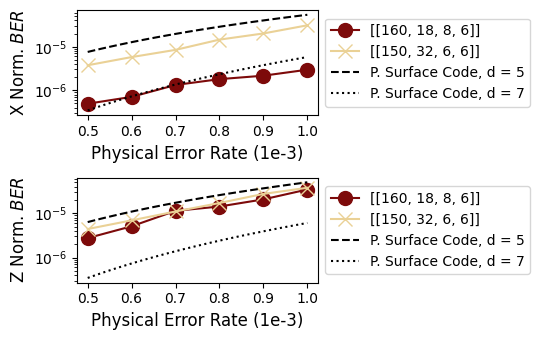

In [135]:
def plot_error_rate_curve(ax, x, y, marker, color, ms, label):
    x = np.array(x)
    y = np.array(y)
    lgx, lgy = np.log(x), np.log(y)
    res = sp.stats.linregress(lgx, lgy)
    a, b = res.slope, res.intercept
    b = np.e**b
    curve = lambda p: b*(p**a)

    x = np.arange(0.5, 1.01, 0.01)
    y = np.array([curve(_x) for _x in x])
    ax.plot(x, y, marker, color=color, ms=ms, label=label)

def add_sc_data_to_ax(ax, mem):
    colors = [c5, c7, c8]
    markers = ['--', ':', '-.']
    for (i,d) in enumerate([5, 7]):
        x, y = get_rsc_error_rates(d, mem)
        x = [1000*_x for _x in x]
        plot_error_rate_curve(ax, x, y, markers[i], 'k', 5, f'P. Surface Code, d = {d}')
#        ax.plot(x, y, markers[i], color='k', ms=5, label=f'SC, d = {d}')

def add_cc_data_to_ax(ax, mem):
    colors = [c5, c7, c8]
    markers = ['--', ':', '-.']
    for (i,d) in enumerate([5, 7]):
        x, y = get_hexcc_error_rates(d, mem)
        x = [1000*_x for _x in x]
        plot_error_rate_curve(ax, x, y, markers[i], 'k', 5, f'C, d = {d}')
#        ax.plot(x, y, markers[i], color='k', ms=5, label=f'CC, d = {d}')
    

def add_code_data_to_ax(ax, family, subfamily, code, marker, color, mx=False):
    data_file = 'basic_memory_x.csv' if mx else 'basic_memory_z.csv'
    x, y = get_error_rates_from_file(f'../../data/protean/{family}/{subfamily}/{code}/v4.4/output/{data_file}')
    x = [1000*_x for _x in x]
    print(code, y)
#    plot_error_rate_curve(ax, x, y, marker, color, 10, format_code_name(code))
    ax.plot(x, y, marker, color=color, ms=10, label=format_code_name(code))
    
## Surface Code Error Rate Plot
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(5.5, 3.5)

#codes = [('4_5', '160_18_8_6'), ('4_6', '96_18_6_4'), ('5_5', '150_32_6_6'), ('5_6', '120_34_6_5')]
codes = [('4_5', '160_18_8_6'), ('5_5', '150_32_6_6')]
markers = ['o-', 'x-', '^-', '^-']
#markers = ['-', '-.']
colors = [c1, c3, c2]
for (i, (sf, c)) in enumerate(codes):
    add_code_data_to_ax(ax1, 'hysc', sf, c, markers[i], colors[i])
    add_code_data_to_ax(ax2, 'hysc', sf, c, markers[i], colors[i], True)
    
add_sc_data_to_ax(ax1, 'z')
add_sc_data_to_ax(ax2, 'x')
for ax in (ax1, ax2):
    ax.set_xlabel('Physical Error Rate (1e-3)', fontsize=12)
    ax.set_yscale('log')
    ax.set_xticks([0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.legend(fontsize=10, bbox_to_anchor=(1.0, 0.5), loc='center left')
ax1.set_ylabel('X Norm. $BER$', fontsize=12)
ax2.set_ylabel('Z Norm. $BER$', fontsize=12)
plt.tight_layout()
plt.savefig('plots/hysc_error_rates.pdf', bbox_inches='tight')

336_88_8_8 (2.51857e-05, 4.51695e-05, 7.71176e-05, 0.000125018, 0.000187137, 0.000268719)
336_88_8_8 (3.12112e-05, 5.46629e-05, 9.19429e-05, 0.000142011, 0.000210112, 0.000301058)
480_148_6_6 (9.49605e-05, 0.000169652, 0.000271072, 0.000424449, 0.000628916, 0.000907186)
480_148_6_6 (0.000100784, 0.000171026, 0.000271962, 0.000428289, 0.000629705, 0.000899099)


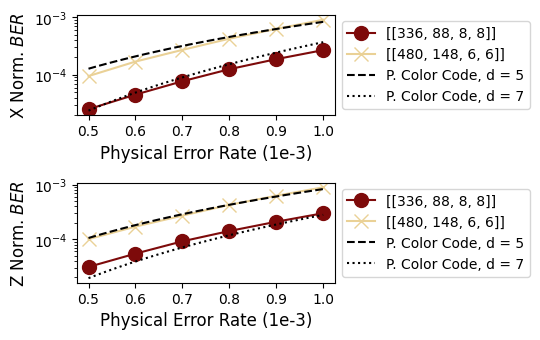

In [111]:
## Color Code Error Rate Plot
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(5.5, 3.5)

codes = [('4_8', '336_88_8_8'), ('4_10', '480_148_6_6')]
markers = ['o-', 'x-', '^-', '^-']
#markers = ['-', '-.']
colors = [c1, c3, c2]
for (i, (sf, c)) in enumerate(codes):
    add_code_data_to_ax(ax1, 'hycc', sf, c, markers[i], colors[i])
    add_code_data_to_ax(ax2, 'hycc', sf, c, markers[i], colors[i], True)

add_cc_data_to_ax(ax1, 'z')
add_cc_data_to_ax(ax2, 'x')
for ax in (ax1, ax2):
    ax.set_xlabel('Physical Error Rate (1e-3)', fontsize=12)
    ax.set_yscale('log')
    ax.legend(fontsize=10, bbox_to_anchor=(1.0, 0.5), loc='center left')
ax1.set_ylabel('X Norm. $BER$', fontsize=12)
ax2.set_ylabel('Z Norm. $BER$', fontsize=12)
plt.tight_layout()
plt.savefig('plots/hycc_error_rates.pdf', bbox_inches='tight')